<a href="https://colab.research.google.com/github/cateto/python4NLP/blob/main/kobert/20210903load_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!pip install transformers==4.4.2

In [106]:
!pip install sentencepiece

In [107]:
!pip install tensorflow_addons

In [108]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import urllib.request
import logging
import tensorflow_addons as tfa

In [109]:
logging.basicConfig(level=logging.ERROR)

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/0902_load_model_test/lucy_data.csv', encoding='cp949')

#라벨 데이터 category 정수로 변환

data_colname = 'contents'
label_colname = 'category'

encoder = LabelEncoder()
encoder.fit(dataset[label_colname])
dataset[label_colname] = encoder.transform(dataset[label_colname])


#이어서 contents 전처리(정제)
dataset[data_colname] = dataset[data_colname].str.replace("\(.*\)|\s-\s.*"," " ,regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("\[.*\]|\s-\s.*"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("\<.*\>|\s-\s.*"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("무단전재 및 재배포 금지"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("무단 전재 및 재배포 금지"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("©"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("ⓒ"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("저작권자"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace(".* 기자", " ", regex=True) #기자 이름에서 오는 유사도 차단
dataset[data_colname] = dataset[data_colname].str.replace("사진 = .*", " ", regex=True) #사진 첨부 문구 삭제
dataset[data_colname] = dataset[data_colname].str.replace("사진=.*", " ", regex=True) #사진 첨부 문구 삭제
dataset[data_colname] = dataset[data_colname].str.replace('\"', "",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)", " ", regex=True) #이메일 주소에서 오는 유사도 차단
dataset[data_colname] = dataset[data_colname].str.replace("\n"," ")
dataset[data_colname] = dataset[data_colname].str.replace("\r"," ")
dataset[data_colname] = dataset[data_colname].str.replace("\t"," ")
dataset[data_colname] = dataset[data_colname].str.replace( "\’" , "", regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("[ ]{2,}"," ",regex=True)

dataset.head()

,Unnamed: 0,id,contents,category,category_val,predict,predict_tag
0,0,DN000000008778200425,공정소득은 코로나 이후 악화되는 자형 양극화에 대비하자는 것 반박 야권의 대선 주...,8,정치,8,정치
1,1,DN000000008808263362,공동대표 및 정책자문위원 등 임명장 수여 내 삶을 지켜주는 나라 신복지 충남포럼 ...,8,정치,8,정치
2,2,DN000000008791388703,바르셀로나 참가 인텔 기가테라 커뮤니케이션즈 를 오픈랜 생태계를 통하여 구축 및 ...,0,IT/과학,0,IT/과학
3,3,DN000000008853835944,더불어민주당 신영대 의원 이 민주당의 혁신과 흥행을 담당할 대선경선기획단에 인선됐...,8,정치,8,정치
4,4,DN000000008834209192,지난 일 미 멕시코 국경지대인 텍사스주 엘패소와 멕시코 시우대드후아레스 사이에서 ...,4,사회,4,사회


In [111]:
num_epochs = 5
num_batch = 16

In [112]:
warmup_ratio = 0.1

t_total = len(dataset) * num_epochs
warmup_step = int(t_total * warmup_ratio)
initializer_range = 0.2

In [113]:
max_seq_len = 128
LR = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=2e-5, first_decay_steps=warmup_step)

In [114]:
def create_model():
  model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)

  input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
  attention_masks_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
  token_type_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

  outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])
  pooled_output = outputs[1]

  optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
  
  pooled_output = tf.keras.layers.Dropout(0.5)(pooled_output)
  prediction = tf.keras.layers.Dense(9, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=initializer_range))(pooled_output)
  cls_model = tf.keras.Model([input_ids_layer, attention_masks_layer, token_type_ids_layer], prediction)
  cls_model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
  cls_model.summary()

  return cls_model

In [115]:
# 새로운 모델 객체를 만듭니다
model = create_model()

# 이전에 저장한 가중치를 로드합니다
model.load_weights('/content/drive/MyDrive/0902_load_model_test/best_model')

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_6 (TFBertModel)   TFBaseModelOutputWit 92186880    input_16[0][0]                   
                                                                 input_17[0][0]             

In [116]:
# 토크나이저 코드 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/monologg/KoBERT-Transformers/master/kobert_transformers/tokenization_kobert.py", filename="tokenization_kobert.py")

('tokenization_kobert.py', <http.client.HTTPMessage at 0x7fdb41626f10>)

In [117]:
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [118]:
def sentence_prediction(example):
    global tokenizer

    input_ids, attention_masks, token_type_ids = [], [], []

    input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)
       
    # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
    padding_count = input_id.count(tokenizer.pad_token_id)
    attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        
    # token_type_id는 세그먼트 임베딩을 위한 것으로 이번 예제는 문장이 1개이므로 전부 0으로 통일.
    token_type_id = [0] * max_seq_len
  
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)

    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    token_type_ids = np.array(token_type_ids)
    return [input_ids, attention_masks, token_type_ids]

def evaluation_predict(sentence):
    data_x = sentence_prediction(sentence)
    predict = model.predict(data_x)

    print('예측 결과 수치', predict)
    print(predict)
    predict_answer = np.argmax(predict[0])
    predict_value = predict[0][predict_answer]
    
    if predict_answer == 0:
      print("(IT/과학 확률 : %.2f) IT/과학 뉴스입니다." % (1-predict_value))
      return 0
    elif predict_answer == 1:
      print("(경제 확률 : %.2f) 경제 뉴스입니다." % predict_value)
      return 1
    elif predict_answer == 2:
      print("(문화 확률 : %.2f) 문화 뉴스입니다." % predict_value)
      return 2
    elif predict_answer == 3:
      print("(미용/건강 확률 : %.2f) 미용/건강 뉴스입니다." % predict_value)
      return 3
    elif predict_answer == 4:
      print("(사회 확률 : %.2f) 사회 뉴스입니다." % predict_value)
      return 4
    elif predict_answer == 5:
      print("(생활 확률 : %.2f) 생활 뉴스입니다." % predict_value)
      return 5
    elif predict_answer == 6:
      print("(스포츠 확률 : %.2f) 스포츠 뉴스입니다." % predict_value)
      return 6
    elif predict_answer == 7:
      print("(연예 확률 : %.2f) 연예 뉴스입니다." % predict_value)
      return 7
    elif predict_answer == 8:
      print("(정치 확률 : %.2f) 정치 뉴스입니다." % predict_value)
      return 8

In [119]:
evaluation_predict('정치 뉴스입니다.')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


예측 결과 수치 [[0.00914906 0.00238315 0.03744877 0.00852321 0.1939369  0.00968546
  0.06027992 0.13331015 0.5452834 ]]
[[0.00914906 0.00238315 0.03744877 0.00852321 0.1939369  0.00968546
  0.06027992 0.13331015 0.5452834 ]]
(정치 확률 : 0.55) 정치 뉴스입니다.


8

In [120]:
result = dataset.copy()
result['predict'] = -1
result['predict_tag'] = 'a'

for idx, x in enumerate(dataset['contents']):
  out_val = evaluation_predict(x)
  result['predict'][idx] = out_val

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


예측 결과 수치 [[1.9553599e-06 7.0339315e-06 1.6601939e-06 3.4436761e-07 1.0732089e-06
  9.5511232e-06 9.8184837e-06 4.4697854e-06 9.9996412e-01]]
[[1.9553599e-06 7.0339315e-06 1.6601939e-06 3.4436761e-07 1.0732089e-06
  9.5511232e-06 9.8184837e-06 4.4697854e-06 9.9996412e-01]]
(정치 확률 : 1.00) 정치 뉴스입니다.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


예측 결과 수치 [[2.1008779e-04 1.4855447e-03 3.3791852e-04 7.4675656e-04 1.0263721e-01
  5.3797709e-04 1.7009997e-03 4.6519600e-04 8.9187831e-01]]
[[2.1008779e-04 1.4855447e-03 3.3791852e-04 7.4675656e-04 1.0263721e-01
  5.3797709e-04 1.7009997e-03 4.6519600e-04 8.9187831e-01]]
(정치 확률 : 0.89) 정치 뉴스입니다.
예측 결과 수치 [[9.9990916e-01 2.3218547e-05 8.1617163e-06 1.6125192e-05 3.9630982e-06
  1.9146984e-05 2.0567559e-06 1.4505152e-05 3.6788858e-06]]
[[9.9990916e-01 2.3218547e-05 8.1617163e-06 1.6125192e-05 3.9630982e-06
  1.9146984e-05 2.0567559e-06 1.4505152e-05 3.6788858e-06]]
(IT/과학 확률 : 0.00) IT/과학 뉴스입니다.
예측 결과 수치 [[9.8678925e-07 2.9220346e-06 1.1176595e-06 3.8147547e-07 5.3557403e-07
  6.3849216e-06 1.6201842e-05 4.4584353e-06 9.9996698e-01]]
[[9.8678925e-07 2.9220346e-06 1.1176595e-06 3.8147547e-07 5.3557403e-07
  6.3849216e-06 1.6201842e-05 4.4584353e-06 9.9996698e-01]]
(정치 확률 : 1.00) 정치 뉴스입니다.
예측 결과 수치 [[2.61921214e-05 2.43629693e-05 3.91163194e-04 1.04791965e-04
  9.98374104e-01 8.61779088e-

In [121]:
result

,Unnamed: 0,id,contents,category,category_val,predict,predict_tag
0,0,DN000000008778200425,공정소득은 코로나 이후 악화되는 자형 양극화에 대비하자는 것 반박 야권의 대선 주...,8,정치,8,a
1,1,DN000000008808263362,공동대표 및 정책자문위원 등 임명장 수여 내 삶을 지켜주는 나라 신복지 충남포럼 ...,8,정치,8,a
2,2,DN000000008791388703,바르셀로나 참가 인텔 기가테라 커뮤니케이션즈 를 오픈랜 생태계를 통하여 구축 및 ...,0,IT/과학,0,a
3,3,DN000000008853835944,더불어민주당 신영대 의원 이 민주당의 혁신과 흥행을 담당할 대선경선기획단에 인선됐...,8,정치,8,a
4,4,DN000000008834209192,지난 일 미 멕시코 국경지대인 텍사스주 엘패소와 멕시코 시우대드후아레스 사이에서 ...,4,사회,4,a
...,...,...,...,...,...,...,...
295,295,DN000000008766398883,파주시가 지난해 월 일 건축물관리법 이 시행됨에 따라 건축물을 해체할 경우 공사 전...,1,경제,5,a
296,296,DN000000008766398882,블랙핑크 서비스를 출시한다 이날 서초동 입체음향 음악 스튜디오 사운드 에서 차원 ...,2,문화,0,a
297,297,DN000000008770346409,일 강제추행 피해 사실을 신고한 뒤 극단적 선택을 한 이모 공군 중사의 영정이 경...,4,사회,4,a
298,298,DN000000008770346519,프로그램 표창원의 뉴스하이킥 출연자 최은영 서울대병원 간호사 진행자 월 일 오늘이...,5,생활,4,a


In [122]:
#정수를 라벨로 인코딩
def category_decoding(lucy_data, label_colname):
    """
      tips: 정수로 된 라벨을 model에 지정된 텍스트 label로 인코딩.
      Args:
          lucy_data : dataframe 형식의 데이터
          label_colname : 라벨의 컬럼명
      Returns:
          lucy_data : DataFrame
    """
    new_column = label_colname+'_tag'
    lucy_data[new_column] = lucy_data[label_colname].astype(str) # 새로운 컬럼 생성
    lucy_data[new_column] = lucy_data[new_column].astype(str) #String형 컬럼으로 바꾸기
  
    label_dict = {'0': 'IT/과학',
      '1': '경제',
      '2': '문화',
      '3': '미용/건강',
      '4': '사회',
      '5': '생활',
      '6': '스포츠',
      '7': '연예',
      '8': '정치'}

    for key, value in label_dict.items():
      print(value)
      lucy_data[new_column] = lucy_data[new_column].str.replace(key, value)

    print("===============Data decoding success! ")
    return lucy_data

In [123]:
category_decoding(result, 'predict')

IT/과학
경제
문화
미용/건강
사회
생활
스포츠
연예
정치
===============Data decoding success! 


,Unnamed: 0,id,contents,category,category_val,predict,predict_tag
0,0,DN000000008778200425,공정소득은 코로나 이후 악화되는 자형 양극화에 대비하자는 것 반박 야권의 대선 주...,8,정치,8,정치
1,1,DN000000008808263362,공동대표 및 정책자문위원 등 임명장 수여 내 삶을 지켜주는 나라 신복지 충남포럼 ...,8,정치,8,정치
2,2,DN000000008791388703,바르셀로나 참가 인텔 기가테라 커뮤니케이션즈 를 오픈랜 생태계를 통하여 구축 및 ...,0,IT/과학,0,IT/과학
3,3,DN000000008853835944,더불어민주당 신영대 의원 이 민주당의 혁신과 흥행을 담당할 대선경선기획단에 인선됐...,8,정치,8,정치
4,4,DN000000008834209192,지난 일 미 멕시코 국경지대인 텍사스주 엘패소와 멕시코 시우대드후아레스 사이에서 ...,4,사회,4,사회
...,...,...,...,...,...,...,...
295,295,DN000000008766398883,파주시가 지난해 월 일 건축물관리법 이 시행됨에 따라 건축물을 해체할 경우 공사 전...,1,경제,5,생활
296,296,DN000000008766398882,블랙핑크 서비스를 출시한다 이날 서초동 입체음향 음악 스튜디오 사운드 에서 차원 ...,2,문화,0,IT/과학
297,297,DN000000008770346409,일 강제추행 피해 사실을 신고한 뒤 극단적 선택을 한 이모 공군 중사의 영정이 경...,4,사회,4,사회
298,298,DN000000008770346519,프로그램 표창원의 뉴스하이킥 출연자 최은영 서울대병원 간호사 진행자 월 일 오늘이...,5,생활,4,사회


In [124]:
label_dict = {'0': 'IT/과학',
  '1': '경제',
  '2': '문화',
  '3': '미용/건강',
  '4': '사회',
  '5': '생활',
  '6': '스포츠',
  '7': '연예',
  '8': '정치'}

label_list = label_dict.values()

In [125]:
label_list = list(label_list)

In [126]:
from sklearn.metrics import classification_report


print(classification_report(result['category'], result['predict'], target_names=label_list))

              precision    recall  f1-score   support

       IT/과학       0.55      0.75      0.63         8
          경제       0.79      0.46      0.58        24
          문화       0.86      0.43      0.57        14
       미용/건강       0.15      0.67      0.25         3
          사회       0.80      0.70      0.75        84
          생활       0.26      0.57      0.35        21
         스포츠       0.88      1.00      0.93        43
          연예       0.98      0.92      0.95        65
          정치       1.00      0.63      0.77        38

    accuracy                           0.74       300
   macro avg       0.70      0.68      0.64       300
weighted avg       0.83      0.74      0.76       300



In [127]:
from sklearn.metrics import confusion_matrix

confusion_matrix(result['category'], result['predict'])

array([[ 6,  0,  0,  1,  0,  1,  0,  0,  0],
       [ 0, 11,  0,  1,  5,  7,  0,  0,  0],
       [ 1,  0,  6,  0,  1,  5,  0,  1,  0],
       [ 0,  0,  0,  2,  0,  1,  0,  0,  0],
       [ 1,  1,  0,  4, 59, 14,  5,  0,  0],
       [ 0,  0,  0,  4,  4, 12,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 43,  0,  0],
       [ 1,  0,  1,  0,  1,  2,  0, 60,  0],
       [ 2,  2,  0,  1,  4,  5,  0,  0, 24]])

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
cm2 = confusion_matrix(result['category'], result['predict'])
cmdf2 = pd.DataFrame(cm2, index=list(map(lambda x: x+'(실제값)', label_list)) , columns=list(map(lambda x: x+'(예측값)', label_list)) )
cmdf2

,IT/과학(예측값),경제(예측값),문화(예측값),미용/건강(예측값),사회(예측값),생활(예측값),스포츠(예측값),연예(예측값),정치(예측값)
IT/과학(실제값),6,0,0,1,0,1,0,0,0
경제(실제값),0,11,0,1,5,7,0,0,0
문화(실제값),1,0,6,0,1,5,0,1,0
미용/건강(실제값),0,0,0,2,0,1,0,0,0
사회(실제값),1,1,0,4,59,14,5,0,0
생활(실제값),0,0,0,4,4,12,1,0,0
스포츠(실제값),0,0,0,0,0,0,43,0,0
연예(실제값),1,0,1,0,1,2,0,60,0
정치(실제값),2,2,0,1,4,5,0,0,24


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_

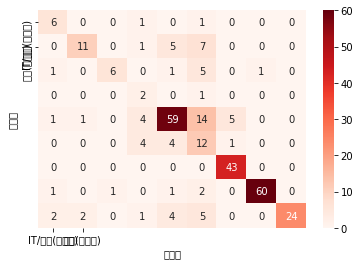

In [129]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_path = "/content/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.xticks([0.5,1.5],list(map(lambda x: x+'(실제값)', label_list)))
plt.yticks([0.5,1.5],list(map(lambda x: x+'(예측값)', label_list)))
plt.show()